In [1]:
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [2]:
print(keras.__version__)

2.2.4-tf


# Loading data for training the model

In [6]:
base_image_dir = os.path.join('/home/raghav/APTOS Kaggle Comp')
train_dir = os.path.join(base_image_dir,'train_images/')
data = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
data["diagnosis"] = data["diagnosis"].astype(str)
data['path'] = data['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
data["id_code"]=data["id_code"].apply(lambda x:x+".png")
#data = data.drop(columns=['id_code'])
#data = data.sample(frac=1).reset_index(drop=True) #shuffle dataframe
data.head(10)

,id_code,diagnosis,path
0,000c1434d8d7.png,2,/home/raghav/APTOS Kaggle Comp/train_images/00...
1,001639a390f0.png,4,/home/raghav/APTOS Kaggle Comp/train_images/00...
2,0024cdab0c1e.png,1,/home/raghav/APTOS Kaggle Comp/train_images/00...
3,002c21358ce6.png,0,/home/raghav/APTOS Kaggle Comp/train_images/00...
4,005b95c28852.png,0,/home/raghav/APTOS Kaggle Comp/train_images/00...
5,0083ee8054ee.png,4,/home/raghav/APTOS Kaggle Comp/train_images/00...
6,0097f532ac9f.png,0,/home/raghav/APTOS Kaggle Comp/train_images/00...
7,00a8624548a9.png,2,/home/raghav/APTOS Kaggle Comp/train_images/00...
8,00b74780d31d.png,2,/home/raghav/APTOS Kaggle Comp/train_images/00...
9,00cb6555d108.png,1,/home/raghav/APTOS Kaggle Comp/train_images/00...


In [8]:
train,test = train_test_split(data,test_size=0.10,random_state=42,stratify=data['diagnosis'])

In [9]:
len(test)

367

# Looking at the distribution of test and train

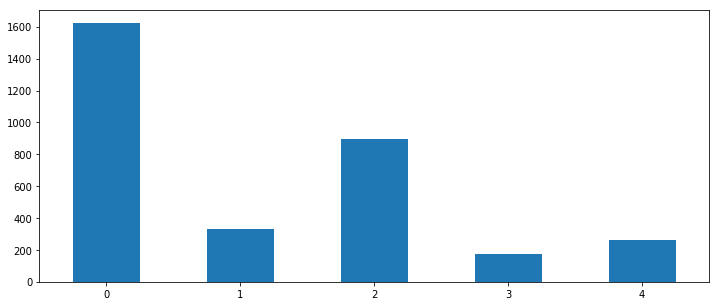

In [13]:
# Look at the distribution of Train Labels
train['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)

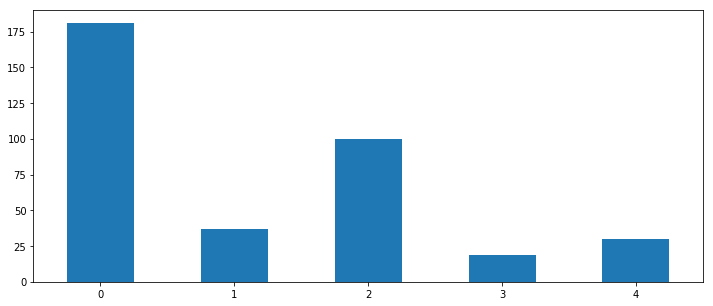

In [14]:
# Look at the distribution of Test labels
test['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)

In [15]:
#Intializing the variables needed for the model
nb_classes = 5
lbls = list(map(str, range(nb_classes)))
batch_size = 100
img_size = 64
nb_epochs = 100

In [18]:
#Preprocessing the data
from keras_preprocessing.image import ImageDataGenerator

# ImageDataGenerator is used to generate training data as well as data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )
test_datagen = ImageDataGenerator(rescale=1./255)

#Creating a Training Validation and Testing generator
train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/home/raghav/APTOS Kaggle Comp/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    classes=lbls,
    target_size=(img_size,img_size),
subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/home/raghav/APTOS Kaggle Comp/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical", 
    classes=lbls,
    target_size=(img_size,img_size),
subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="/home/raghav/APTOS Kaggle Comp/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical", 
    classes=lbls,
    target_size=(img_size,img_size))



Found 2472 images belonging to 5 classes.
Found 823 images belonging to 5 classes.
Found 367 images belonging to 5 classes.


In [19]:
train_generator.image_shape

(64, 64, 3)

# Creating a Model

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D

In [21]:

#Funtion to create a model
def create_model(img_size,activation_layers="relu",padding="same",
                activation_output="softmax",optimizer='adam',
                loss='categorical_crossentropy',dropout=0.50):  
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation=activation_layers, padding=padding,input_shape=(img_size,img_size,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=3, activation=activation_layers))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=3, activation=activation_layers))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(60,activation=activation_layers,kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(5, activation=activation_output))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        
    
    return model

#Funtion to adjust the learning rate based on validation loss threshold values
def reduce_lr(monitor='val_loss',factor=0.2,patience = 10, min_lr=0.001):
    
    lr = ReduceLROnPlateau(monitor=monitor, factor=factor,
                              patience=patience, min_lr=min_lr)
    
    return lr

# Funtion to terminate early based on validation loss threshold values
def early_stop(monitor='val_loss',mode='min',verbose=1,patience=10):
    
    es = EarlyStopping(monitor=monitor, mode=mode, verbose=verbose, patience=patience)
    
    return es

In [22]:
#Initializing the functions
model = create_model(img_size)
es = early_stop()
lr = reduce_lr()

#Fit the model to train data
history = model.fit_generator(generator=train_generator,
                                    validation_data=valid_generator,
                                    steps_per_epoch=train.shape[0]/batch_size, 
                                    epochs=nb_epochs,
                                    max_queue_size=16,
                                    workers=4,
                                    use_multiprocessing=True,
                                    callbacks=[es,lr],
                                    validation_steps=train.shape[0]/batch_size,  
                                    verbose=1)

Epoch 1/100


W0819 14:01:33.852379 139869587019584 deprecation.py:323] From /home/raghav/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


33/32 [==============================] - 128s 4s/step - loss: 1.3965 - accuracy: 0.4859 - val_loss: 1.2659 - val_accuracy: 0.4927
Epoch 2/100
33/32 [==============================] - 95s 3s/step - loss: 1.1858 - accuracy: 0.5590 - val_loss: 1.0942 - val_accuracy: 0.6259
Epoch 3/100
33/32 [==============================] - 109s 3s/step - loss: 1.0385 - accuracy: 0.6544 - val_loss: 1.0213 - val_accuracy: 0.6540
Epoch 4/100
33/32 [==============================] - 127s 4s/step - loss: 0.9686 - accuracy: 0.6812 - val_loss: 0.9332 - val_accuracy: 0.6732
Epoch 5/100
33/32 [==============================] - 100s 3s/step - loss: 0.9373 - accuracy: 0.6895 - val_loss: 0.9299 - val_accuracy: 0.6846
Epoch 6/100
33/32 [==============================] - 107s 3s/step - loss: 0.9086 - accuracy: 0.6942 - val_loss: 0.9124 - val_accuracy: 0.6781
Epoch 7/100
33/32 [==============================] - 127s 4s/step - loss: 0.8945 - accuracy: 0.7042 - val_loss: 0.9017 - val_accuracy: 0.6813
Epoch 8/100
33/32 [

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

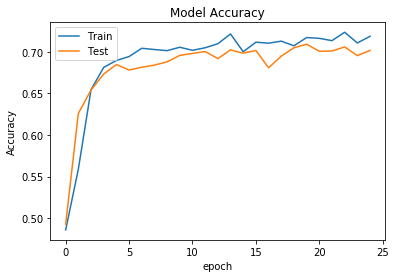

In [25]:
#Accuracy Plot

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


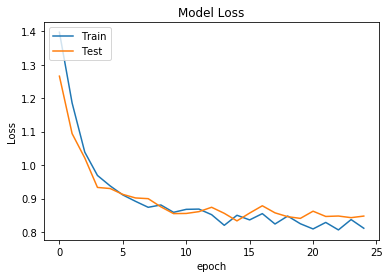

In [26]:
#Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [46]:
model.save('regularized_model.h5')

In [27]:
evaluation=model.evaluate_generator(test_generator)

In [28]:
evaluation

[0.8072641640901566, 0.71934605]

In [29]:
test_dir = os.path.join(base_image_dir,'test_images/')
test_data = pd.read_csv(os.path.join(base_image_dir, 'test.csv'))
test_data['path'] = test_data['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
test_data["id_code"]=test_data["id_code"].apply(lambda x:x+".png")
#data = data.drop(columns=['id_code'])
#data = data.sample(frac=1).reset_index(drop=True) #shuffle dataframe
test_data.head(10)

,id_code,path
0,0005cfc8afb6.png,/home/raghav/APTOS Kaggle Comp/test_images/000...
1,003f0afdcd15.png,/home/raghav/APTOS Kaggle Comp/test_images/003...
2,006efc72b638.png,/home/raghav/APTOS Kaggle Comp/test_images/006...
3,00836aaacf06.png,/home/raghav/APTOS Kaggle Comp/test_images/008...
4,009245722fa4.png,/home/raghav/APTOS Kaggle Comp/test_images/009...
5,009c019a7309.png,/home/raghav/APTOS Kaggle Comp/test_images/009...
6,010d915e229a.png,/home/raghav/APTOS Kaggle Comp/test_images/010...
7,0111b949947e.png,/home/raghav/APTOS Kaggle Comp/test_images/011...
8,01499815e469.png,/home/raghav/APTOS Kaggle Comp/test_images/014...
9,0167076e7089.png,/home/raghav/APTOS Kaggle Comp/test_images/016...


In [32]:
comp_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory="/home/raghav/APTOS Kaggle Comp/test_images/",
    x_col="id_code",
    batch_size=1,
    shuffle=False,
    class_mode=None, 
    target_size=(img_size,img_size))

Found 1928 images.


In [33]:
comp_generator.reset()
predict=model.predict_generator(comp_generator, steps = len(comp_generator.filenames))

In [34]:
predict.shape

(1928, 5)

In [42]:
filenames=comp_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(predict,axis=1)})


In [44]:
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

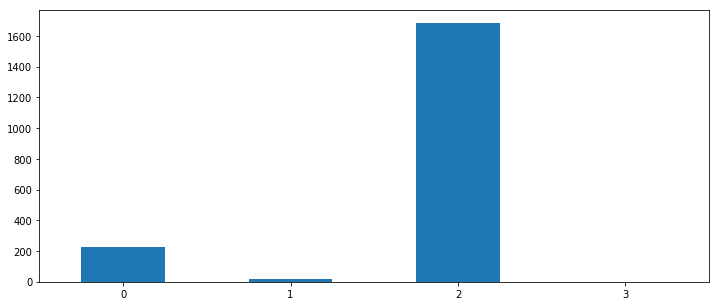

In [63]:
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

In [64]:
plot_model(model,show_shapes=True,to_file='model.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
